# Analysis of NHL Tweets

I'm interested in understanding more about how NHL fans on Twitter interact with their team's handles throughout the season. I also want to measure the sentiment of tweets over team, and see if sentiment has a relation to the team's performance throughout the season.

To do this, I will scrape NHL-related tweets. I'll also be using 2 different game outcome datasets. Seasons prior to the 2018-2019 season will use the Kaggle NHL games dataset. Current season standings are available from https://www.hockey-reference.com/leagues/NHL_2019_games.html

In [1]:
import datetime as dt
import os

#data collection packages
import csv
import logging
import requests
from bs4 import BeautifulSoup
from pathlib import Path
from twitterscraper import query_tweets

import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

# data processing packages
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from textblob import TextBlob

# data vis packages
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Collection

The data I want:
<ul>
    <li>A list of current NHL team handles</li>
    <li>All tweets for teams in a given time period (e.g. since the beginning of the season; 2018 playoffs)</li>
    <li>Team rankings at a given time period</li>
    <li>Historical dates and outcomes of games for a given time period, for a given team(s)</li>

In [2]:
tweets_datafile = 'data/tweets.csv' # for storing raw tweet data
tweets_polarity_datafile = 'data/tweets_polarities.csv' # for storing cleaned data with sentiment polarities

In [3]:
def get_team_handles():
    chromedriver = os.environ['CHROMEDRIVER']

    if not Path(chromedriver).exists():
        logging.info('Installing Chrome driver')
        driver = webdriver.Chrome(ChromeDriverManager().install())
    
    print('Fetching team handles from Twitter')

    browser = webdriver.Chrome(chromedriver)
    url = 'https://twitter.com/NHL/lists/nhl-team-accounts/members?lang=en'
    browser.get(url)
    time.sleep(1)
    body = browser.find_element_by_tag_name('body')

    for i in range(5):
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)

    users = browser.find_elements_by_class_name('username')

    team_handles = []
    for user in users:
        if user.text and user.text not in team_handles:
            team_handles.append(user.text)
            print('Added team handle: ', user.text)
    print('Successfully found ', len(team_handles), ' handles!')
    return team_handles

In [4]:
team_handles = get_team_handles()

Fetching team handles from Twitter
Added team handle:  @NHLSeattle_
Added team handle:  @GoldenKnights
Added team handle:  @NHLJets
Added team handle:  @MapleLeafs
Added team handle:  @NHL
Added team handle:  @NHLBruins
Added team handle:  @Senators
Added team handle:  @NJDevils
Added team handle:  @FlaPanthers
Added team handle:  @DallasStars
Added team handle:  @PredsNHL
Added team handle:  @TBLightning
Added team handle:  @SanJoseSharks
Added team handle:  @NHLFlames
Added team handle:  @Avalanche
Added team handle:  @BlueJacketsNHL
Added team handle:  @StLouisBlues
Added team handle:  @BuffaloSabres
Added team handle:  @NYRangers
Added team handle:  @ArizonaCoyotes
Added team handle:  @AnaheimDucks
Added team handle:  @CanadiensMTL
Added team handle:  @NHLCanes
Added team handle:  @NHLFlyers
Added team handle:  @LAKings
Added team handle:  @mnwild
Added team handle:  @Canucks
Added team handle:  @DetroitRedWings
Added team handle:  @NYIslanders
Added team handle:  @EdmontonOilers
A

In [5]:
def collect_tweets(begindate=dt.date(2018, 10, 3), enddate=dt.date.today(), filepath=tweets_datafile, handles=team_handles):
    logger = logging.getLogger('twitterscraper')
    logger.disabled = True
    
    with open(filepath, 'w') as csv_file:
        fieldnames = ['user', 'team', 'timestamp', 'likes', 'replies', 'retweets', 'text']
        csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        csv_writer.writeheader()
        print("Collecting tweets:")
        for team_handle in handles:
            team_tweets = query_tweets(team_handle, limit=10000, begindate=begindate, enddate=enddate)
            print("found ", len(team_tweets), " tweets for ", team_handle)
            for tweet in team_tweets:
                csv_writer.writerow({'user': tweet.user,
                                     'team': team_handle,
                                     'timestamp': tweet.timestamp,
                                     'likes': tweet.likes,
                                     'replies': tweet.replies,
                                     'retweets': tweet.retweets,
                                     'text': tweet.text})

In [6]:
# For simplicity - taking the maximum sentence polarity in a tweet
# TODO: improve by building own classifier. 
def create_polarities(filepath=tweets_datafile, polarity_filepath=tweets_polarity_datafile):
    print('Adding polarities...')
    dataframe = pd.read_csv(filepath)
    size = len(dataframe.index)
    dataframe['polarity'] = np.nan
    dataframe['positive'] = 0
    dataframe['negative'] = 0
    for index, row in dataframe.iterrows():
        sentence = row['text']
        if isinstance(sentence, str):
            polarity = TextBlob(sentence).sentiment.polarity
            dataframe.at[index, 'polarity'] = polarity
            if polarity > 0:
                dataframe.at[index, 'positive'] = 1
            elif polarity < 0:
                dataframe.at[index, 'negative'] = 1
    print('Polarities added')
    dataframe.to_csv(polarity_filepath)

In [7]:
if not Path(tweets_polarity_datafile).exists():
    if not Path(tweets_datafile).exists():
        collect_tweets()
    create_polarities()

In [8]:
tweets_data = pd.read_csv(tweets_polarity_datafile, parse_dates = ['timestamp'])
tweets_data.describe()

,Unnamed: 0,likes,replies,retweets,polarity,positive,negative
count,375118.000000,375118.000000,375118.000000,375118.000000,370824.000000,375118.000000,375118.000000
mean,187558.500000,12.676238,0.624366,1.925770,0.113498,0.377423,0.146413
std,108287.383476,152.642734,4.968061,48.595299,0.314647,0.484743,0.353520
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,93779.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,187558.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,281337.750000,2.000000,1.000000,0.000000,0.250000,1.000000,0.000000
max,375117.000000,42722.000000,1010.000000,23333.000000,1.000000,1.000000,1.000000


Collect game outcomes

In [9]:
# TODO: use a smart lookup to find
team_names_handles = {
    'Tampa Bay Lightning': '@TBLightning',
    'Calgary Flames': '@NHLFlames',
    'San Jose Sharks': '@SanJoseSharks',
    'Toronto Maple Leafs': '@MapleLeafs',
    'Winnipeg Jets': '@NHLJets',
    'New York Islanders': '@NYIslanders',
    'Nashville Predators': '@PredsNHL',
    'Montreal Canadiens':'@CanadiensMTL',
    'Boston Bruins': '@NHLBruins',
    'Washington Capitals': '@Capitals',
    'Vegas Golden Knights': '@GoldenKnights',
    'Columbus Blue Jackets': '@BlueJacketsNHL',
    'Pittsburgh Penguins': '@penguins',
    'Carolina Hurricanes': '@NHLCanes',
    'Buffalo Sabres': '@BuffaloSabres',
    'Dallas Stars': '@DallasStars',
    'Minnesota Wild': '@mnwild',
    'St. Louis Blues': '@StLouisBlues',
    'Philadelphia Flyers': '@NHLFlyers',
    'Vancouver Canucks': '@Canucks',
    'Florida Panthers': '@FlaPanthers',
    'Colorado Avalanche': '@Avalanche',
    'New York Rangers': '@NYRangers',
    'Arizona Coyotes': '@ArizonaCoyotes',
    'Chicago Blackhawks': '@NHLBlackhawks',
    'Edmonton Oilers': '@EdmontonOilers',
    'Los Angeles Kings': '@LAKings',
    'Anaheim Ducks': '@AnaheimDucks',
    'Detroit Red Wings': '@DetroitRedWings',
    'New Jersey Devils': '@NJDevils',
    'Ottawa Senators': '@Senators'
}

In [10]:
def collect_game_outcomes():
    r = requests.get('https://www.hockey-reference.com/leagues/NHL_2019_games.html')
    df = pd.read_html(r.text)[0]
    for index,row in df.iterrows():
        visitor = row['Visitor']
        visitor_goals = row['G']
        home = row['Home']
        home_goals = row['G.1']
        df.at[index, 'home_team_id'] = team_names_handles[home]
        df.at[index, 'away_team_id'] = team_names_handles[visitor]
    df = df.rename(columns={ df.columns[0]: "date_time", df.columns[4]: 'home_goals', df.columns[2]: 'away_goals' })
    return df

In [11]:
def generate_game_outcomes(team, season, startdate, endate):
    if season <= 2017:
        startdate = pd.Timestamp(startdate)
        endate = pd.Timestamp(endate)
    
        team_info = get_team_info()
        team_id = team_info[team_info['handle']==team]['team_id'].iloc[0]

    else:
        team_id = team
        
    
    if season <= 2017:
        game_info = pd.read_csv('data/game.csv', parse_dates=True)
        game_info['date_time'] = pd.to_datetime(game_info['date_time'], format="%Y-%m-%dT%H:%M:%SZ")

    else: 
        game_info = collect_game_outcomes()
        game_info['date_time'] = pd.to_datetime(game_info['date_time'], format="%Y %m %d")

    game_info = game_info[(game_info['home_team_id']==team_id) | (game_info['away_team_id']==team_id)]
    game_info = game_info[(game_info['date_time'] >= startdate) & (game_info['date_time'] <= endate)]
    
    for index, row in game_info.iterrows():
        if row['home_team_id'] == team_id:
            game_info.at[index, 'won'] = row['home_goals'] > row['away_goals']
        else:
            game_info.at[index, 'won'] = row['away_goals'] > row['home_goals']
    game_info.won = game_info.won.astype(int)
    return game_info[['date_time', 'won']].sort_values(by=['date_time'])

In [12]:
# handles = handles_to_teams()
team_of_interest = '@MapleLeafs'
season_start = dt.date(2018, 10, 3)
season_end = dt.date(2019, 4, 3)
team_winning_streak = generate_game_outcomes(team_of_interest, 2018, season_start, season_end)
team_winning_streak.head()

,date_time,won
1,2018-10-03,1
27,2018-10-06,0
29,2018-10-07,1
37,2018-10-09,1
46,2018-10-11,1


### Pre-processing
To make the data easier for processing, I drop null values and any duplicated tweets before proceeding.
I also hard-coded the current rankings (as of February 10, 2019) and the 2017-2018 season rankings. This will later be replaced by an API or additional web-scraping. 

In [13]:
def preprocess(df):
    return df.dropna().drop_duplicates()

In [14]:
team_tweets = preprocess(tweets_data[tweets_data['team'] != '@NHL'])
team_tweets.head()

,Unnamed: 0,user,team,timestamp,likes,replies,retweets,text,polarity,positive,negative
0,0,ShaunanKruse,@NHLSeattle_,2018-11-16 19:39:45,1,0,0,I've been super impressed with Bauer. He's fei...,0.151088,1,0
1,1,SeatownCyclops,@NHLSeattle_,2018-11-16 16:38:44,2,0,0,Here's an opportunity to evolve and submit des...,0.283333,1,0
2,2,Amocat_Jedi,@NHLSeattle_,2018-11-16 08:07:39,0,0,0,Can they be the radio callers for the @NHLSeat...,0.625000,1,0
3,3,D_Poole03,@NHLSeattle_,2018-11-16 02:58:47,1,0,0,Still say @OvgSeattle @NHLSeattle_ need to com...,0.000000,0,0
4,4,ohshitcircuit,@NHLSeattle_,2018-11-15 23:19:23,0,0,0,@NHLSeattle_ sponsor my zamboni Pride float pl...,0.000000,0,0


In [15]:
# TODO: use API to get rankings
current_rankings = {
    '@TBLightning': 1,
    '@NHLFlames': 2,
    '@SanJoseSharks': 3,
    '@MapleLeafs': 4,
    '@NHLJets': 5,
    '@NYIslanders': 6,
    '@PredsNHL': 7,
    '@CanadiensMTL': 8,
    '@NHLBruins': 9,
    '@Capitals': 10,
    '@GoldenKnights': 11,
    '@BlueJacketsNHL': 12,
    '@penguins': 13,
    '@NHLCanes': 14,
    '@BuffaloSabres': 15,
    '@DallasStars': 16,
    '@mnwild': 17,
    '@StLouisBlues': 18,
    '@NHLFlyers': 19,
    '@Canucks': 20,
    '@FlaPanthers': 21,
    '@Avalanche': 22,
    '@NYRangers': 23,
    '@ArizonaCoyotes': 24,
    '@NHLBlackhawks': 25,
    '@EdmontonOilers': 26,
    '@LAKings': 27,
    '@AnaheimDucks': 28,
    '@DetroitRedWings': 29,
    '@NJDevils': 30,
    '@Senators': 31
}

playoff_2018_rankings = {
    '@TBLightning': 3, 
    '@MapleLeafs':9, 
    '@NJDevils':13, 
    '@NHLBruins':8, 
    '@penguins':6, 
    '@BlueJacketsNHL':10, 
    '@NHLFlyers':10, 
    '@Capitals': 1,
    '@Avalanche':10, 
    '@NHLJets': 4, 
    '@PredsNHL':5, 
    '@mnwild':13, 
    '@LAKings':15, 
    '@GoldenKnights': 2, 
    '@AnaheimDucks':15, 
    '@SanJoseSharks':6
}
playoff_teams = list(playoff_2018_rankings.keys())

# Analysis
### Aggregate the data by team and see high-level statistics

Create a summary by team of the total number of tweets, likes, replies, retweets, engagement per tweet, and proportion of positive tweets (positive_tweet_count/total_tweets), and use this to see how the team's ranking is correlated with tweet engagement & polarity

In [16]:
# team_summary = pd.DataFrame(columns=['team', 'tweets', 'ppos', 'likes', 'replies', 'retweets', 'total_engagement'])
def summary_table(df, rankings=current_rankings):
    row_list = []
    for team in team_handles:
        if team != '@NHL' and team != '@NHLSeattle_':
            total_tweets = df[df['team']==team]['team'].count()
            positive_tweets = df[(df['positive']==1) & (df['team']==team)]['positive'].count()
            total_likes = df[df['team']==team]['likes'].sum()
            total_replies = df[df['team']==team]['replies'].sum()
            total_retweets = df[df['team']==team]['retweets'].sum()
            total_engagement = total_likes + total_replies + total_retweets

            row_list.append({
                'team': team,
                'tweets': total_tweets,
                'ppos': positive_tweets/total_tweets*100,
                'total_likes': total_likes,
                'total_replies': total_replies,
                'total_retweets': total_retweets,
                'total_engagement': total_engagement,
                'engagement_per_tweet': total_engagement/total_tweets*100,
                'ranking': rankings[team]
            })
    return pd.DataFrame(row_list)

In [17]:
team_summary = summary_table(team_tweets)
team_summary.head()

,engagement_per_tweet,ppos,ranking,team,total_engagement,total_likes,total_replies,total_retweets,tweets
0,1733.025812,41.623319,11,@GoldenKnights,353156,308295,13145,31716,20378
1,943.351477,33.772356,5,@NHLJets,194104,159017,10447,24640,20576
2,1307.420169,43.817335,4,@MapleLeafs,269407,221950,12155,35302,20606
3,2106.364908,37.549960,9,@NHLBruins,210805,177339,7094,26372,10008
4,1186.942149,38.541565,31,@Senators,122077,95375,7152,19550,10285


In [18]:
team_summary.describe()

,engagement_per_tweet,ppos,ranking,total_engagement,total_likes,total_replies,total_retweets,tweets
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,1540.151553,37.915645,16.000000,171225.225806,143212.677419,7068.032258,20944.516129,11260.096774
std,424.857842,3.805857,9.092121,57187.955811,50127.487141,1716.676236,6752.200209,3081.956688
min,831.052173,28.284583,1.000000,85856.000000,69467.000000,5624.000000,8356.000000,10008.000000
25%,1188.181439,36.980976,8.500000,124998.000000,103823.000000,6326.500000,16816.000000,10269.500000
50%,1599.544088,38.541565,16.000000,171980.000000,141396.000000,6689.000000,21782.000000,10287.000000
75%,1796.689757,40.172956,23.500000,193560.000000,161611.000000,6914.000000,24750.000000,10310.500000
max,2626.122608,43.817335,31.000000,353156.000000,308295.000000,13145.000000,35302.000000,20606.000000


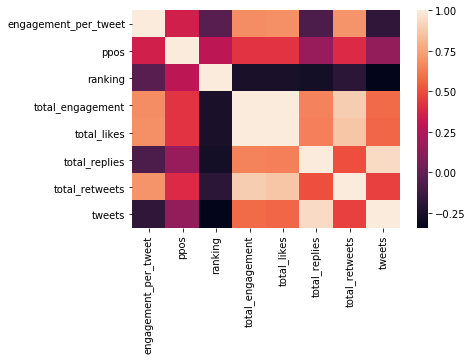

In [19]:
sns.heatmap(team_summary.corr())

Observations:
<ul>
    <li>Negative correlation between ranking & engagement (better performing = higher overall engagement)</li>
    <li>Moderate positive correlation between ranking & ppos (portion of tweets that are positive), meaning higher-performing teams have a higher portion of negative tweets</li>
</ul>

### Plot polarity vs. performance over time

In [20]:
def normalize_axis_dates(df1, df2):
    row_list = []
    for date in df1['timestamp']:
        if date not in df2['date_time']:
            won = 0
            for index, row in df2.iterrows():
                if date >= row['date_time']:
                    won = row['won']
            row_list.append({'date_time': date, 'won': won})
        normalized_df = df2.append(pd.DataFrame(row_list))
    return normalized_df.sort_values(by='date_time')

In [21]:
team_of_interest_tweets = team_tweets[(team_tweets['team']==team_of_interest)]
print("Tweets for team ", team_of_interest)
team_of_interest_tweets.head()

Tweets for team  @MapleLeafs


,Unnamed: 0,user,team,timestamp,likes,replies,retweets,text,polarity,positive,negative
26561,26561,j_jubes,@MapleLeafs,2018-12-18 23:59:50,0,0,0,Nylander ftw #fansgofurther,0.0,0,0
26562,26562,sensfansdoyle,@MapleLeafs,2018-12-18 23:59:37,0,0,0,Kappin,0.0,0,0
26563,26563,seanonizzle,@MapleLeafs,2018-12-18 23:59:22,0,0,0,@meganxoxtaylor,0.0,0,0
26564,26564,MapleLeafs,@MapleLeafs,2018-12-18 23:59:05,190,0,30,Getting ready to go in the Garden State. #Leaf...,0.2,1,0
26565,26565,SamDuncan1323,@MapleLeafs,2018-12-18 23:58:54,0,0,0,#FansGoFurther Marner,0.0,0,0


In [22]:
# convert the string timestamp to the same format used by the game_outcomes
# aggregate average polarity by timestamp grouped by day
team_of_interest_tweets['timestamp'] = pd.to_datetime(team_of_interest_tweets['timestamp'], format="%Y-%m-%d %H:%M:%S")
polarity_by_day = team_of_interest_tweets.groupby(team_of_interest_tweets.timestamp.dt.strftime('%Y %m %d'))['polarity'].mean().reset_index(name='polarity').sort_values('timestamp')

win_by_day = team_winning_streak.groupby(team_winning_streak.date_time.dt.strftime('%Y %m %d'))['won'].sum().reset_index(name='won').sort_values('date_time')
win_by_day = normalize_axis_dates(polarity_by_day, win_by_day)

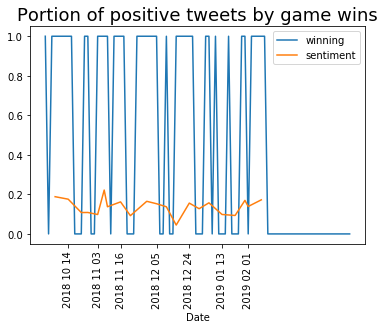

In [23]:
fig, ax = plt.subplots()

plt.title('Portion of positive tweets by game wins', fontsize=18)
plt.xlabel('Date')

plt.plot(win_by_day.date_time, win_by_day.won, label='winning')
plt.plot(polarity_by_day.timestamp, polarity_by_day.polarity, label='sentiment')

x_ticks = []
for index, row in polarity_by_day.iterrows():
    if index%3==1:
        x_ticks.append(row['timestamp'])
ax.xaxis.set_ticks(x_ticks)

plt.xticks(rotation=90)
plt.legend()

plt.show()

# 2018 Playoffs Analysis

In [24]:
playoff_tweets_path = 'data/2018_playoff_tweets.csv'
regular_season_path = 'data/2018_regular_season_tweets.csv' # nothing here yet
playoffs_start = dt.date(2018,4,11)
playoffs_end = dt.date(2018,6,7)

if not Path(regular_season_path).exists():
    start_2018 = dt.date(2017, 10, 4)
    end_2018 = dt.date(2018,4,8)
    collect_data(begindate=start_2018, enddate=end_2018, filepath=regular_season_path)
if not Path(playoff_tweets_path).exists():
    collect_data(begindate=playoffs_start, enddate=playoffs_end, filepath=playoff_tweets_path, handles = playoff_teams)

In [25]:
playoff_tweets = pd.read_csv(playoff_tweets_path)

In [26]:
playoff_tweets.head()

,user,team,timestamp,likes,replies,retweets,text
0,HockeyMom_Jody,@TBLightning,2018-05-19 23:59:48,0,1,0,Who do you want to win this series?
1,ZachJensen45,@TBLightning,2018-05-19 23:59:19,0,2,0,If the trip is called the play is blown dead w...
2,stuttterbuttter,@TBLightning,2018-05-19 23:58:56,6,1,1,Out here in Cali but there ZERO chance i was m...
3,BluezBayou,@TBLightning,2018-05-19 23:58:42,0,0,0,#WEWANTHECUP Bolts
4,bekahboo1290,@TBLightning,2018-05-19 23:58:19,0,1,0,Lol dude you sound like a child.


In [27]:
playoff_polarities_path = 'data/playoff_polarities.csv'
if not Path(playoff_polarities_path).exists():
    create_polarities(filepath=playoff_tweets_path, polarity_filepath='data/playoff_polarities.csv')

In [28]:
playoffs_tweets = pd.read_csv(playoff_polarities_path)
playoffs_tweets.count()

Unnamed: 0    6861
user          6861
team          6861
timestamp     6861
likes         6861
replies       6861
retweets      6861
text          6801
polarity      6801
positive      6861
negative      6861
dtype: int64

In [29]:
playoffs_tweets.head()

,Unnamed: 0,user,team,timestamp,likes,replies,retweets,text,polarity,positive,negative
0,0,HockeyMom_Jody,@TBLightning,2018-05-19 23:59:48,0,1,0,Who do you want to win this series?,0.80,1,0
1,1,ZachJensen45,@TBLightning,2018-05-19 23:59:19,0,2,0,If the trip is called the play is blown dead w...,0.15,1,0
2,2,stuttterbuttter,@TBLightning,2018-05-19 23:58:56,6,1,1,Out here in Cali but there ZERO chance i was m...,-0.35,0,1
3,3,BluezBayou,@TBLightning,2018-05-19 23:58:42,0,0,0,#WEWANTHECUP Bolts,0.00,0,0
4,4,bekahboo1290,@TBLightning,2018-05-19 23:58:19,0,1,0,Lol dude you sound like a child.,0.60,1,0


In [30]:
playoff_summary = summary_table(playoffs_tweets).dropna()

In [31]:
playoff_summary

,engagement_per_tweet,ppos,ranking,team,total_engagement,total_likes,total_replies,total_retweets,tweets
0,1177.222222,44.166667,11,@GoldenKnights,4238,3595,210,433,360
1,1063.593750,38.750000,5,@NHLJets,6807,5527,337,943,640
2,472.000000,46.333333,4,@MapleLeafs,1416,1156,113,147,300
3,702.931034,45.689655,9,@NHLBruins,4077,3240,279,558,580
5,1834.230769,48.846154,30,@NJDevils,4769,3631,144,994,260
8,720.769231,40.576923,7,@PredsNHL,3748,3140,261,347,520
9,652.500000,35.000000,1,@TBLightning,3132,2590,195,347,480
10,2462.045455,38.863636,3,@SanJoseSharks,10833,8925,334,1574,440
12,1424.642857,38.571429,22,@Avalanche,3989,3579,154,256,280
13,1894.520548,44.383562,12,@BlueJacketsNHL,6915,6021,169,725,365


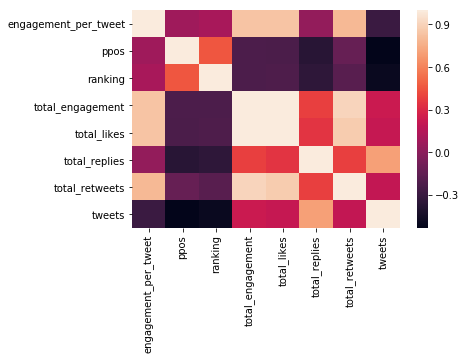

In [32]:
sns.heatmap(playoff_summary.corr())

Observations:
<ul>
    <li>Like above, negative correlation between ranking and overall engagement: better-performing teams have higher engagement by likes, replies, total tweets, retweets, and engagement per tweet</li>
    <li>A moderate, positive correlation exists between ranking and "ppos" (portion of positive tweets): higher-ranked teams (i.e. poorer performers) have a higher propertion of positive tweets than those lower in the rankings
</ul>

### Question: Does the sentiment of a team's tweets correlate to how that team is currently performing?
To solve this:
<ul>
    <li>Choose any team</li>
    <li>Get data on the win/lose streak for that team -- I used a Kaggle NHL dataset and filtered for the 2018 playoffs season</li>
    <li>Plot the streak as a step function, on the same axis as:</li>
    <li>Plot the team's tweet sentiment as a function of time (grouped by days)</li>
    <li>Note: to use the same axes for the step- and line plots, I had to normalize the dates in the outcomes dataframe</li>

In [33]:
team_of_interest = '@NHLBruins'

In [34]:
# Fetches the team info from the team_info Kaggle NHL games dataset
def get_team_info():
    team_info = pd.read_csv('data/team_info.csv')
    for index, row in team_info.iterrows():
        name = row['teamName'].replace(" ", "").lower()
        city = row['shortName'].replace(" ", "").lower()
        if name == 'predators':
            team_info.at[index, 'handle'] = '@PredsNHL'
        elif name == 'hurricanes':
            team_info.at[index, 'handle'] = '@NHLCanes'
        else:
            for handle in team_handles:
                if name in handle.lower() or city in handle.lower():
                    team_info.at[index, 'handle'] = handle
    return team_info.dropna()

In [35]:
game_outcomes = generate_game_outcomes(team_of_interest, 2017, playoffs_start, playoffs_end)
print("Game outcomes for team ", team_of_interest)
game_outcomes

Game outcomes for team  @NHLBruins


,date_time,won
501,2018-04-12 23:00:00,1
502,2018-04-15 00:00:00,1
503,2018-04-16 23:00:00,0
504,2018-04-19 23:00:00,1
505,2018-04-22 00:00:00,0
506,2018-04-23 23:00:00,0
507,2018-04-25 23:30:00,1
480,2018-04-28 19:00:00,1
481,2018-04-30 23:00:00,0
482,2018-05-02 23:00:00,0


In [36]:
team_of_interest_tweets = playoffs_tweets[(playoff_tweets['team']==team_of_interest)]
print("Tweets for team ", team_of_interest)
team_of_interest_tweets.head()

Tweets for team  @NHLBruins


,Unnamed: 0,user,team,timestamp,likes,replies,retweets,text,polarity,positive,negative
1040,1040,conorpetz16,@NHLBruins,2018-05-31 23:54:29,7,0,0,Hopefully Rick Nash isn't being offered a cont...,0.000000,0,0
1041,1041,Heather68240691,@NHLBruins,2018-05-31 23:51:33,0,0,0,Get better soon boys.,0.500000,1,0
1042,1042,dreamhockey37,@NHLBruins,2018-05-31 23:51:09,5,1,0,Or the fact that there's literally no reasonab...,-0.427778,0,1
1043,1043,KomulainenTom,@NHLBruins,2018-05-31 23:50:33,1,0,0,@travis8marsh,0.000000,0,0
1044,1044,dreamhockey37,@NHLBruins,2018-05-31 23:49:00,0,1,0,"All good, I think he'll be re-signed for 2 yea...",0.850000,1,0


In [37]:
# convert the string timestamp to the same format used by the game_outcomes
# aggregate average polarity by timestamp grouped by day
team_of_interest_tweets['timestamp'] = pd.to_datetime(team_of_interest_tweets['timestamp'], format="%Y-%m-%d %H:%M:%S")
polarity_by_day = team_of_interest_tweets.groupby(team_of_interest_tweets.timestamp.dt.strftime('%Y %m %d'))['polarity'].mean().reset_index(name='polarity').sort_values('timestamp')


In [38]:
# aggregate winning outcomes by timestamp grouped by day
win_by_day = game_outcomes.groupby(game_outcomes.date_time.dt.strftime('%Y %m %d'))['won'].sum().reset_index(name='won').sort_values('date_time')

In [39]:
eliminated_on = win_by_day.tail(1)['date_time'].iloc[0]
print(team_of_interest, " was eliminated on ", eliminated_on)

@NHLBruins  was eliminated on  2018 05 06


### Winning Streak step function

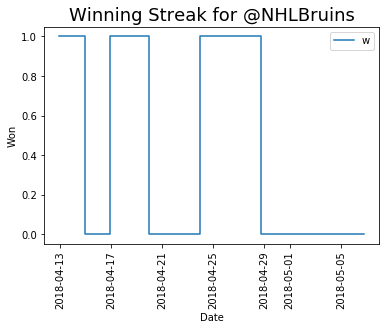

In [40]:
plt.figure()
plt.title('Winning Streak for ' + team_of_interest, fontsize=18)
plt.xlabel('Date')
plt.ylabel('Won')

plt.step(game_outcomes['date_time'], game_outcomes['won'])
plt.legend('winning')
plt.xticks(rotation=90)

plt.show()

In [41]:
likes_by_day = team_of_interest_tweets.groupby(team_of_interest_tweets.timestamp.dt.strftime('%Y %m %d'))['likes'].sum().reset_index(name='likes').sort_values('timestamp')

In [42]:
win_by_day = normalize_axis_dates(polarity_by_day, win_by_day)

### Average sentiment by game outcomes

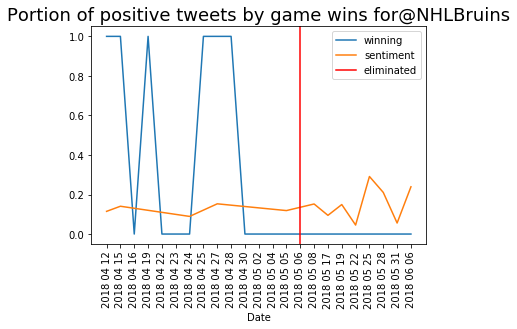

In [43]:
plt.title('Portion of positive tweets by game wins for' + team_of_interest, fontsize=18)
plt.xlabel('Date')

plt.plot(win_by_day.date_time, win_by_day.won, label='winning')
plt.plot(polarity_by_day.timestamp, polarity_by_day.polarity, label='sentiment')
plt.axvline(eliminated_on, color = 'r', label = 'eliminated')

plt.xticks(rotation=90)
plt.legend()

plt.show()

### Likes per day (scaled) by Game Outcome

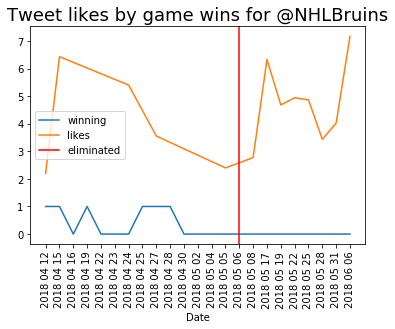

In [44]:
plt.title('Tweet likes by game wins for ' + team_of_interest, fontsize=18)
plt.xlabel('Date')

plt.plot(win_by_day.date_time, win_by_day.won, label='winning')
plt.plot(likes_by_day.timestamp, np.log(likes_by_day.likes), label='likes')
plt.axvline(eliminated_on, color = 'r', label = 'eliminated')

plt.xticks(rotation=90)
plt.legend()

plt.show()